<h1>TED</h1>

**TED** is a non-profit devoted to spreading ideas, usually in the form of short, powerful talks (18 minutes or less). TED began in 1984 as a conference where Technology, Entertainment and Design converged, and today covers almost all topics — from science to business to global issues — in more than 100 languages.

**TED** is now a global community, welcoming people from every discipline and culture who seek a deeper understanding of the world. TED believes passionately in the power of ideas to change attitudes, lives and, ultimately, the world.

Credits: TED.com

<img src = 'TED_Talks.jpg' alt ='Kindly download TED_Talks.jpg file in the same directory as this .ipynb file'>

Here we will explore EDA and Data Visualization of an open sourced dataset related to **TED Talks**. We will perform Data Cleaning, Data Preprocessing, EDA and Data Visualization. To perform these we will use libraries like **Pandas** and **Matplotlib** in python.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.colors as cm
from wordcloud import WordCloud
from PIL import Image

<h2> 1. Data Loading and Overview

In [2]:
df=pd.read_csv('data.csv')
df.head()

,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...


Dataset Credit: https://www.kaggle.com/datasets/ashishjangra27/ted-talks

In [3]:
print("Shape of the Dataset: ",df.shape, end='\n\n')

Shape of the Dataset:  (5440, 6)



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5440 non-null   object
 1   author  5439 non-null   object
 2   date    5440 non-null   object
 3   views   5440 non-null   int64 
 4   likes   5440 non-null   int64 
 5   link    5440 non-null   object
dtypes: int64(2), object(4)
memory usage: 255.1+ KB


<h3>Observation

* The Dataset has 6 Columns:-
    * title: The title of the event
     * Type: String
     * Number of Entries: 5440
    * author: The Speaker for the event
     * Type: String
     * Number of Entries: 5439
    * date: Date of Event
     * Type: String
     * Number of Entries: 5440
    * views: Number of views the video link got till date
     * Type: Integer
     * Number of Entries: 5440
    * likes: Number of likes the video link got till date
     * Type: Integer
     * Number of Entries: 5440
    * link: URL link to the website having the video
     * Type: String
     * Number of Entries: 5440

<h2> 2. Data Cleaning

**As per TED.com, TED first started in 1984, so any dates of TED Talks before 1984 might be a noise and we need to get rid of it**

In [5]:
df.drop(list(df[pd.to_datetime(df['date']).dt.year<1984].index), axis=0, inplace=True)

In [6]:
df[pd.to_datetime(df['date']).dt.year<1984]

,title,author,date,views,likes,link


**Let's check for presence of any missing data**

In [7]:
df.isnull().any()

title     False
author     True
date      False
views     False
likes     False
link      False
dtype: bool

> **'author'** column has some missing data. Let's check the rows having missing data in **'author'** column

In [8]:
df[df['author'].isnull()]

,title,author,date,views,likes,link
3039,Year In Ideas 2015,NaN,December 2015,532,15,https://ted.com/talks/year_in_ideas_2015


> Since only one row has NaN value, we can remove the entire row. It won't effect the Dataset much

In [9]:
df.dropna(axis=0, inplace=True)
df.isnull().any()

title     False
author    False
date      False
views     False
likes     False
link      False
dtype: bool

In [10]:
print("Shape of the Dataset: ",df.shape)

Shape of the Dataset:  (5435, 6)


**Now let's check for duplicate data**

> In the Dataset, we can have duplicate values in column **'author'**, **'date'**, **'views'** and **'likes'**. So we won't be checking for duplicacy in those columns

In [11]:
df[df.duplicated()]

,title,author,date,views,likes,link


In [12]:
df[df.duplicated(subset=['link'])]

,title,author,date,views,likes,link


In [13]:
df[df.duplicated(subset=['title'])]

,title,author,date,views,likes,link


> There is no duplicate row in the Dataset. Also the **'title'** and **'link'** columns doesn't have any duplicate values

<h2> 3. Data Preprocessing </h2>

**Dropping the 'link' column**

> **'link'** column doesn't serve any meaningful purpose in the analysis of our Dataset. We can remove the column without much effect on the Dataset

In [14]:
df.drop(['link'], axis=1, inplace=True)
df.head()

,title,author,date,views,likes
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72


**Feature Engineering: Engineering a new column**

> One important feature that we can develop is the weighted ratio of **'likes'** w.r.t **'views'**. This will help us in understanding the success of the Event or the success of the Speaker

> Weighted ratio is calculated as the Product of Ratio of **likes** to **views** and Inverse of Number of Days passed from the Date of Posting of Video till 1st July 2022 and multiplying it by 100

In [15]:
df['inv_days_passed']=pd.to_datetime('July 2022') - pd.to_datetime(df['date'], errors='coerce')
df['inv_days_passed']=df['inv_days_passed'].apply(lambda x: 1/(x.days))

df['likes/views (%)'] = (df['likes'].values/df['views'].values)*100

df['weighted_likes/views (%)'] = (df['inv_days_passed'].values)*(df['likes/views (%)'].values)*100

df.drop(['inv_days_passed'], axis=1, inplace=True)

df.head()

,title,author,date,views,likes,likes/views (%),weighted_likes/views (%)
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,2.970297,1.401084
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,2.990654,1.993769
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,2.912621,0.961261
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,2.810304,1.029416
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,3.000000,1.098901


**Segregating Month and Year from 'date' column**

> For better analysis of the data, we should segregate the month from the year in the **'date'** column

In [16]:
df['Month'] = pd.to_datetime(df['date']).dt.month_name()
df['Year'] = pd.to_datetime(df['date']).dt.year
df.drop(['date'], axis=1, inplace=True)
df.head()

,title,author,views,likes,likes/views (%),weighted_likes/views (%),Month,Year
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,404000,12000,2.970297,1.401084,December,2021
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,214000,6400,2.990654,1.993769,February,2022
2,How play can spark new ideas for your business,Martin Reeves,412000,12000,2.912621,0.961261,September,2021
3,Why is China appointing judges to combat clima...,James K. Thornton,427000,12000,2.810304,1.029416,October,2021
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,2400,72,3.000000,1.098901,October,2021


**Removing STOPWORDS from the text of 'title' column**

> We need to remove Stopwords and special characters from **'title'** column for better analysis

In [17]:
stop_word = stopwords.words("english")
stop_word.remove('not')

prep_title=[]
for title in df['title']:
    title = re.sub(r'[^A-Za-z0-9]+', ' ', title)
    
    t=[]
    for w in (title.lower().split()):
        if w not in stop_word:
            t.append(w.upper())
    prep_title.append(' '.join(t))

df['prep_title']=prep_title
df.head()

,title,author,views,likes,likes/views (%),weighted_likes/views (%),Month,Year,prep_title
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,404000,12000,2.970297,1.401084,December,2021,CLIMATE ACTION NEEDS NEW FRONTLINE LEADERSHIP
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,214000,6400,2.990654,1.993769,February,2022,DARK HISTORY OVERTHROW HAWAII
2,How play can spark new ideas for your business,Martin Reeves,412000,12000,2.912621,0.961261,September,2021,PLAY SPARK NEW IDEAS BUSINESS
3,Why is China appointing judges to combat clima...,James K. Thornton,427000,12000,2.810304,1.029416,October,2021,CHINA APPOINTING JUDGES COMBAT CLIMATE CHANGE
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,2400,72,3.000000,1.098901,October,2021,CEMENT CARBON PROBLEM 2 WAYS FIX


> Rearranging the Columns properly

**Reindexing and Renaming the Columns of the dataset**

In [18]:
df = df.reindex(columns=['title', 'prep_title', 'author', 'Month', 'Year', 'views', 'likes', 'likes/views (%)', 'weighted_likes/views (%)'])
df.head()

,title,prep_title,author,Month,Year,views,likes,likes/views (%),weighted_likes/views (%)
0,Climate action needs new frontline leadership,CLIMATE ACTION NEEDS NEW FRONTLINE LEADERSHIP,Ozawa Bineshi Albert,December,2021,404000,12000,2.970297,1.401084
1,The dark history of the overthrow of Hawaii,DARK HISTORY OVERTHROW HAWAII,Sydney Iaukea,February,2022,214000,6400,2.990654,1.993769
2,How play can spark new ideas for your business,PLAY SPARK NEW IDEAS BUSINESS,Martin Reeves,September,2021,412000,12000,2.912621,0.961261
3,Why is China appointing judges to combat clima...,CHINA APPOINTING JUDGES COMBAT CLIMATE CHANGE,James K. Thornton,October,2021,427000,12000,2.810304,1.029416
4,Cement's carbon problem — and 2 ways to fix it,CEMENT CARBON PROBLEM 2 WAYS FIX,Mahendra Singhi,October,2021,2400,72,3.000000,1.098901


In [19]:
df.columns = ['Title', 'Preprocessed_Title', 'Author', 'Month', 'Year', 'Views', 'Likes', 'Likes/Views (%)', 'Weighted_Likes/Views (%)']
df.head()

,Title,Preprocessed_Title,Author,Month,Year,Views,Likes,Likes/Views (%),Weighted_Likes/Views (%)
0,Climate action needs new frontline leadership,CLIMATE ACTION NEEDS NEW FRONTLINE LEADERSHIP,Ozawa Bineshi Albert,December,2021,404000,12000,2.970297,1.401084
1,The dark history of the overthrow of Hawaii,DARK HISTORY OVERTHROW HAWAII,Sydney Iaukea,February,2022,214000,6400,2.990654,1.993769
2,How play can spark new ideas for your business,PLAY SPARK NEW IDEAS BUSINESS,Martin Reeves,September,2021,412000,12000,2.912621,0.961261
3,Why is China appointing judges to combat clima...,CHINA APPOINTING JUDGES COMBAT CLIMATE CHANGE,James K. Thornton,October,2021,427000,12000,2.810304,1.029416
4,Cement's carbon problem — and 2 ways to fix it,CEMENT CARBON PROBLEM 2 WAYS FIX,Mahendra Singhi,October,2021,2400,72,3.000000,1.098901


<h2> 4. Exploratory Data Analysis

**Plotting Year wise distribution of TED Talks**

In [20]:
x_year=df['Year'].value_counts().sort_index().index
y_year=df['Year'].value_counts().sort_index().values

colormap=['#fbfbfb']*len(x_year)

l=[list(x_year).index(i) for i in df['Year'].value_counts()[0:4].index]
colormap[l[0]]=colormap[l[1]]=colormap[l[2]]=colormap[l[3]]='#ed1100'

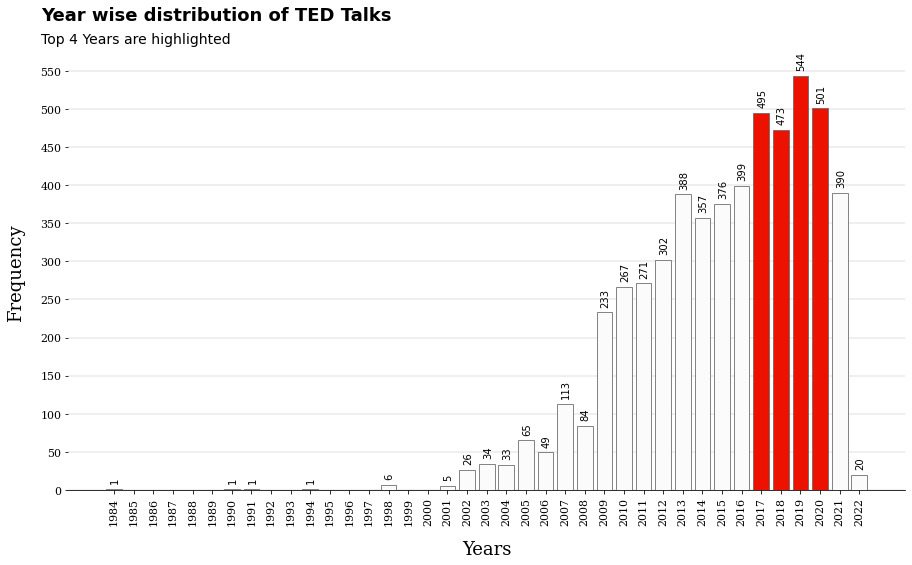

In [21]:
fig, ax = plt.subplots(1,1, figsize=(15,8))

fig.text(0.1,0.94, "Year wise distribution of TED Talks", fontsize=18, fontweight='600')
fig.text(0.1,0.9, "Top 4 Years are highlighted", fontsize=14, fontweight='500')

ax.bar(x_year,y_year, width=0.8, edgecolor='#686868', linewidth=0.8, color=colormap)

for i in range(len(y_year)):
    ax.annotate(f"{y_year[i]}", xy=(x_year[i]-0.2, y_year[i]+10), rotation=90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xticks(list(range(x_year.min(),x_year.max()+1)), fontfamily='serif', rotation=90, fontsize=11)
plt.yticks(list(range(0,y_year.max()+50,50)), fontfamily='serif', fontsize=11)

ax.grid(axis='y', linewidth=0.4)
ax.set_axisbelow(True)

plt.xlabel("Years", fontfamily='serif', fontsize=18, labelpad=15)
plt.ylabel("Frequency", fontfamily='serif', fontsize=18, labelpad=15)
plt.show()

> **OBSERVATIONS**
> * Most number of TED Talks happened in the year 2019
> * Number of TED Talks in the year 2020 and 2021 have decreased probably due to Covid-19
> * The number of TED talks have significantly increased in the year 2002 and in the year 2009 from it's previous years

**Plotting Month wise distribution of TED Talks**

In [22]:
month_alph_order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df1=pd.DataFrame(df['Month'].value_counts()).reindex(month_alph_order, axis=0)

x_month=df1['Month'].keys()
y_month=df1['Month'].values

colormap=['#fbfbfb']*len(x_month)

l=[list(x_month).index(i) for i in df['Month'].value_counts()[0:4].index]
colormap[l[0]]=colormap[l[1]]=colormap[l[2]]=colormap[l[3]]='#ed1100'

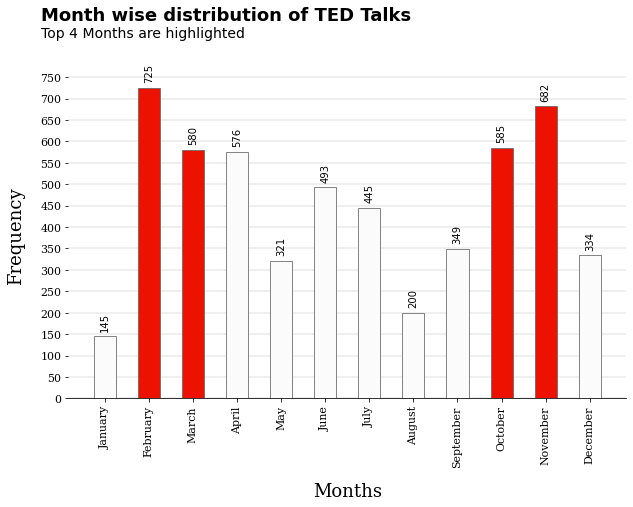

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

fig.text(0.087,1.0, "Month wise distribution of TED Talks", fontsize=18, fontweight='600')
fig.text(0.087,0.96, "Top 4 Months are highlighted", fontsize=14, fontweight='500')

ax.bar(x_month,y_month, width=0.5, edgecolor='#686868', linewidth=0.8, color=colormap)

for i in range(len(y_month)):
    ax.annotate(f"{y_month[i]}", xy=(x_month[i], y_month[i]+35), va = 'center', ha='center', rotation=90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xticks(x_month, fontfamily='serif', fontsize=11, rotation=90)
plt.yticks(list(range(0,y_month.max()+50,50)), fontfamily='serif', fontsize=11)

ax.grid(axis='y', linewidth=0.4)
ax.set_axisbelow(True)

plt.xlabel("Months", fontfamily='serif', fontsize=18, labelpad=15)
plt.ylabel("Frequency", fontfamily='serif', fontsize=18, labelpad=15)
plt.show()

> **OBSERVATIONS**
> * Most number of TED Talks happened in the month of February and the least number of TED Talks happened in the month of January
> * The top 4 months are February, March, October and November

**Creating a DataFrame which has Author wise Count (number of TED Talks), Cumulative Views, Cumulative Likes and Cumulative Weighted Percentage of Likes to Views**

In [24]:
auth=df.groupby(['Author'])
d=dict()
for author, group in auth:
    d[author]={'Count': group['Author'].count(), 'Views': group['Views'].sum(), 'Likes': group['Likes'].sum(), 'Weighted_Likes/Views_(%)': group['Weighted_Likes/Views (%)'].sum()}

In [25]:
df1=pd.DataFrame(d).T
df1.head()

,Count,Views,Likes,Weighted_Likes/Views_(%)
B.E.A.T. NYC,1.0,3200.0,98.0,0.125822
Belle and Sebastian,1.0,23000.0,690.0,1.098901
Butterscotch,1.0,31000.0,933.0,0.319160
Climbing PoeTree,1.0,12000.0,367.0,0.228575
Countdown,1.0,11000.0,332.0,1.105561


**Plotting Bar chart of Top 10 Authors with most number of TED Talks**

In [26]:
x_author=list(df1.sort_values('Count', ascending=False)[:10].index)
x_author.reverse()
y_count=np.sort(df1.sort_values('Count', ascending=False)[:10].Count.values)

colormap=['#fbfbfb']*10

colormap[-1]=colormap[-2]=colormap[-3]=colormap[-4]='#ed1100'

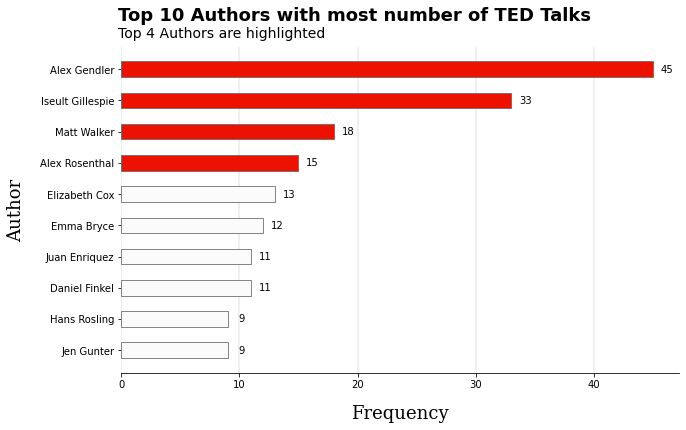

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

fig.text(0.12,0.94, "Top 10 Authors with most number of TED Talks", fontsize=18, fontweight='600')
fig.text(0.12,0.9, "Top 4 Authors are highlighted", fontsize=14, fontweight='500')

ax.barh(x_author,y_count, height=0.5, edgecolor='#686868', linewidth=0.8, color=colormap)

for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", xy=(p.get_x()+p.get_width()+1.2, p.get_y()+p.get_height()/2), va='center', ha='center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(axis='x', linewidth=0.4)
ax.set_axisbelow(True)

plt.xlabel("Frequency", fontfamily='serif', fontsize=18, labelpad=15)
plt.ylabel("Author", fontfamily='serif', fontsize=18, labelpad=15)
plt.show()

> **OBSERVATIONS**
> * **Alex Gendler** has the most number of TED Talks followed by **Iseult Gillespie**

**Plotting Bar chart of Top 10 Authors with most views on TED Talk videos**

In [28]:
x_author=list(df1.sort_values('Views', ascending=False)[:10].index)
x_author.reverse()
y_views=np.sort(df1.sort_values('Views', ascending=False)[:10].Views.values)

colormap=['#fbfbfb']*10

colormap[-1]=colormap[-2]=colormap[-3]=colormap[-4]='#ed1100'

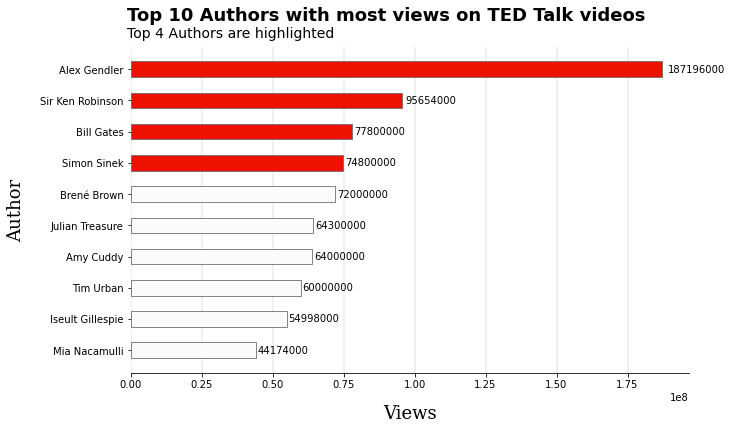

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

fig.text(0.12,0.94, "Top 10 Authors with most views on TED Talk videos", fontsize=18, fontweight='600')
fig.text(0.12,0.9, "Top 4 Authors are highlighted", fontsize=14, fontweight='500')

ax.barh(x_author,y_views, height=0.5, edgecolor='#686868', linewidth=0.8, color=colormap)

for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", xy=(p.get_x()+p.get_width()*1.01, p.get_y()+p.get_height()/2), va='center', ha='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(axis='x', linewidth=0.4)
ax.set_axisbelow(True)

plt.xlabel("Views", fontfamily='serif', fontsize=18, labelpad=15)
plt.ylabel("Author", fontfamily='serif', fontsize=18, labelpad=15)
plt.show()

> **OBSERVATIONS**
> * **Alex Gendler** has the most Views on videos of TED Talks with cumulative views of 187,196,000
> * The difference between top author and second top author is huge (almost a jump of 100%)

**Plotting Bar chart of Top 10 Authors with most likes on TED Talk videos**

In [30]:
x_author=list(df1.sort_values('Likes', ascending=False)[:10].index)
x_author.reverse()
y_likes=np.sort(df1.sort_values('Likes', ascending=False)[:10].Likes.values)

colormap=['#fbfbfb']*10

colormap[-1]=colormap[-2]=colormap[-3]=colormap[-4]='#ed1100'

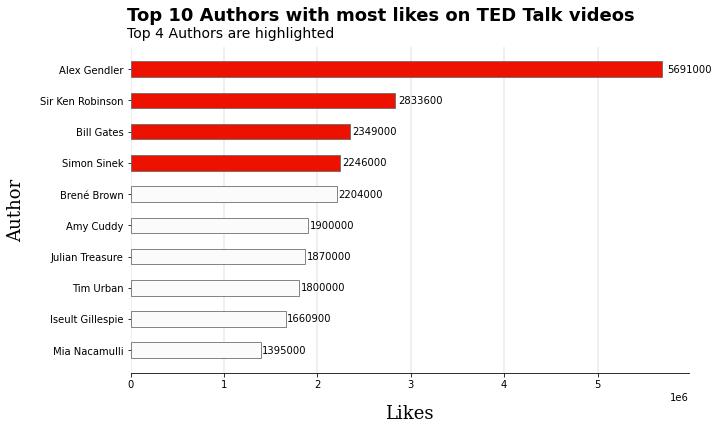

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

fig.text(0.12,0.94, "Top 10 Authors with most likes on TED Talk videos", fontsize=18, fontweight='600')
fig.text(0.12,0.9, "Top 4 Authors are highlighted", fontsize=14, fontweight='500')

ax.barh(x_author,y_likes, height=0.5, edgecolor='#686868', linewidth=0.8, color=colormap)

for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", xy=(p.get_x()+p.get_width()*1.01, p.get_y()+p.get_height()/2), va='center', ha='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(axis='x', linewidth=0.4)
ax.set_axisbelow(True)

plt.xlabel("Likes", fontfamily='serif', fontsize=18, labelpad=15)
plt.ylabel("Author", fontfamily='serif', fontsize=18, labelpad=15)
plt.show()

> **OBSERVATIONS**
> * **Alex Gendler** has the most Likes on videos of TED Talks with cumulative views of 5,691,000
> * The difference between top author and second top author is huge (almost a jump of 100%)

**Plotting Bar chart of Top 10 most successful Authors**

In [32]:
**Plotting Bar chart of Top 10 Authors with most views on TED Talk videos**x_author=list(df1.sort_values('Weighted_Likes/Views_(%)', ascending=False)[:10].index)
x_author.reverse()
y_wt_likes_views=np.sort(df1.sort_values('Weighted_Likes/Views_(%)', ascending=False)[:10]['Weighted_Likes/Views_(%)'].values)

colormap=['#fbfbfb']*10

colormap[-1]=colormap[-2]=colormap[-3]=colormap[-4]='#ed1100'

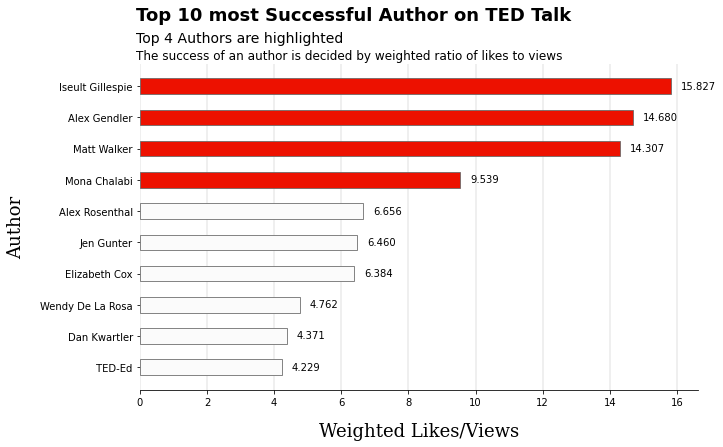

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

fig.text(0.12,0.98, "Top 10 most Successful Author on TED Talk", fontsize=18, fontweight='600')
fig.text(0.12,0.93, "Top 4 Authors are highlighted", fontsize=14, fontweight='500')
fig.text(0.12,0.89, "The success of an author is decided by weighted ratio of likes to views", fontsize=12, fontweight='500')

ax.barh(x_author,y_wt_likes_views, height=0.5, edgecolor='#686868', linewidth=0.8, color=colormap)

for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", xy=(p.get_x()+p.get_width()+0.3, p.get_y()+p.get_height()-0.4), va='bottom', ha='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(axis='x', linewidth=0.4)
ax.set_axisbelow(True)

plt.xlabel("Weighted Likes/Views", fontfamily='serif', fontsize=18, labelpad=15)
plt.ylabel("Author", fontfamily='serif', fontsize=18, labelpad=15)
plt.show()

> **OBSERVATIONS**
> * Top 10 Successful Authors are shown in the above plot
> * Success of an author is calculated by the cumulative sum of weighted ratio of Likes to Views of all the videos of the Author
> * Weighted ratio of a video is calculated as the **Product of Ratio of Likes to Views and Inverse of Number of Days passed from the Date of Posting of Video till 1st July 2022 and multiplying it by 100**
> * The most successful author is **Iseult Gillespie** followed closely by **Alex Gendler** and **Matt Walker**

In [34]:
df2=df1.loc[['Iseult Gillespie', 'Alex Gendler', 'Matt Walker', 'Mona Chalabi']][['Count', 'Views', 'Likes']]
df2['Views']=df2['Views'].values/(1000000)
df2['Likes']=df2['Likes'].values/(100000)
df2.rename(columns={'Views': 'Views_(x10^6)', 'Likes': 'Likes_(x10^5)'}, inplace=True)
df2

,Count,Views_(x10^6),Likes_(x10^5)
Iseult Gillespie,33.0,54.998,16.609
Alex Gendler,45.0,187.196,56.910
Matt Walker,18.0,27.948,8.375
Mona Chalabi,9.0,4.222,1.258


**Plotting Cumulative Bar chart with Count, Views, Likes of Top 4 most successful Authors**

In [35]:
df2=df2.reindex(columns=['Views_(x10^6)', 'Likes_(x10^5)', 'Count'])
df2=df2.T
df2

,Iseult Gillespie,Alex Gendler,Matt Walker,Mona Chalabi
Views_(x10^6),54.998,187.196,27.948,4.222
Likes_(x10^5),16.609,56.910,8.375,1.258
Count,33.000,45.000,18.000,9.000


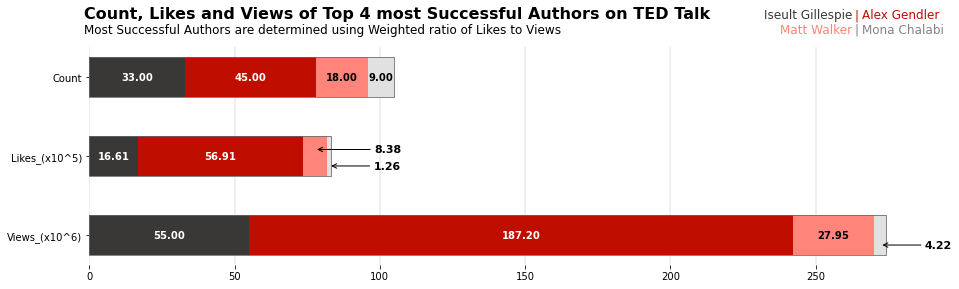

In [36]:
fig, ax = plt.subplots(1,1,figsize=(15,4))

fig.text(0.12,0.98, "Count, Likes and Views of Top 4 most Successful Authors on TED Talk", fontsize=16, fontweight='600')
fig.text(0.12,0.93, "Most Successful Authors are determined using Weighted ratio of Likes to Views", fontsize=12, fontweight='500')

ax.barh(df2.index, df2['Iseult Gillespie'].values, height=0.5, color='#393836')
ax.barh(df2.index, df2['Alex Gendler'].values, height=0.5, color='#bf0e00', left=df2['Iseult Gillespie'].values)
ax.barh(df2.index, df2['Matt Walker'].values, height=0.5, color='#ff847a', left=df2['Alex Gendler'].values+df2['Iseult Gillespie'].values)
ax.barh(df2.index, df2['Mona Chalabi'].values, height=0.5, color='#e1e1e1', left=df2['Matt Walker'].values+df2['Alex Gendler'].values+df2['Iseult Gillespie'].values)
ax.barh(df2.index, df2['Iseult Gillespie'].values+df2['Alex Gendler'].values+df2['Matt Walker'].values+df2['Mona Chalabi'].values, fill=False, height=0.5, edgecolor='#686868', linewidth=0.8)

for i, p in enumerate(ax.patches[0:3]):
    ax.annotate(f"{df2.iloc[i][0]:.2f}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()/2), va='center', ha='center', color='white', fontweight='600')

for i, p in enumerate(ax.patches[3:6]):
    ax.annotate(f"{df2.iloc[i][1]:.2f}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()/2), va='center', ha='center', color='white', fontweight='600')

for i, p in enumerate(ax.patches[6:9]):
    if  i!=1:
        ax.annotate(f"{df2.iloc[i][2]:.2f}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()/2), va='center', ha='center', fontweight='600')
    else:
        ax.annotate(f"{df2.iloc[i][2]:.2f}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()/1.5), xytext=(p.get_x()+p.get_width()/2+25, p.get_y()+p.get_height()/1.5), va='center', ha='center', fontsize='11', fontweight='600', arrowprops={'arrowstyle':'->'})
    
for i, p in enumerate(ax.patches[9:12]):
    if i==2:
        ax.annotate(f"{df2.iloc[i][3]:.2f}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()/2), va='center', ha='center', fontweight='600')
    else:
        ax.annotate(f"{df2.iloc[i][3]:.2f}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()/4), xytext=(p.get_x()+p.get_width()/2+20, p.get_y()+p.get_height()/4), va='center', ha='center', fontsize='11', fontweight='600', arrowprops={'arrowstyle':'->'})

fig.text(0.75,0.98, "Iseult Gillespie", fontsize=12, fontweight='500', color='#393836')
fig.text(0.8335,0.98, "|", fontsize=12, fontweight='500', color='#bf0e00')
fig.text(0.84,0.98, "Alex Gendler", fontsize=12, fontweight='500', color='#bf0e00')   
fig.text(0.7645,0.93, "Matt Walker", fontsize=12, fontweight='500', color='#ff847a')
fig.text(0.8335,0.93, "|", fontsize=12, fontweight='500', color='#858585')
fig.text(0.84,0.93, "Mona Chalabi", fontsize=12, fontweight='500', color='#858585')  

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(axis='x', linewidth=0.4)
ax.set_axisbelow(True)

> **OBSERVATIONS**
> * From the above plot, we can find that by pure numbers **Alex Gendler** has lead in all the features but in terms of success given by cumulative sum of weighted ratio of likes to views, **Iseult Gillespie** takes the lead

**Plotting Bar chart of Top 10 most successful TED Talks**

In [37]:
df3 = df.sort_values('Weighted_Likes/Views (%)', ascending=False)[:10][['Title', 'Author', 'Weighted_Likes/Views (%)']]
df3

,Title,Author,Weighted_Likes/Views (%)
18,How we're reducing the climate impact of elect...,Tim Dunn,2.013889
11,How do jetpacks work? And why don't we all hav...,Richard Browning,2.003130
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,1.993769
6,The myth of Narcissus and Echo,Iseult Gillespie,1.941748
8,What nature can teach us about sustainable bus...,Erin Meezan,1.919192
22,The myth of Gawain and the Green Knight,Dan Kwartler,1.900585
16,"What is ""normal"" and what is ""different""?",Yana Buhrer Tavanier,1.888163
26,Can you outsmart the fallacy that divided a na...,Elizabeth Cox,1.836547
51,Why is it so hard to escape poverty?,Ann-Helén Bay,1.731123
49,One company at a time,American Family Insurance,1.723757


In [38]:
x_title=list(df3['Title'].values)
x_title.reverse()
y_wt_likes_views=list(df3['Weighted_Likes/Views (%)'].values)
y_wt_likes_views.reverse()
a_authors=list(df3['Author'].values)
a_authors.reverse()
colormap=['#fbfbfb']*10

colormap[-1]=colormap[-2]=colormap[-3]=colormap[-4]='#ed1100'

colormap_annotate=['#393836']*10
colormap_annotate[-1]=colormap_annotate[-2]=colormap_annotate[-3]=colormap_annotate[-4]='#fbfbfb'

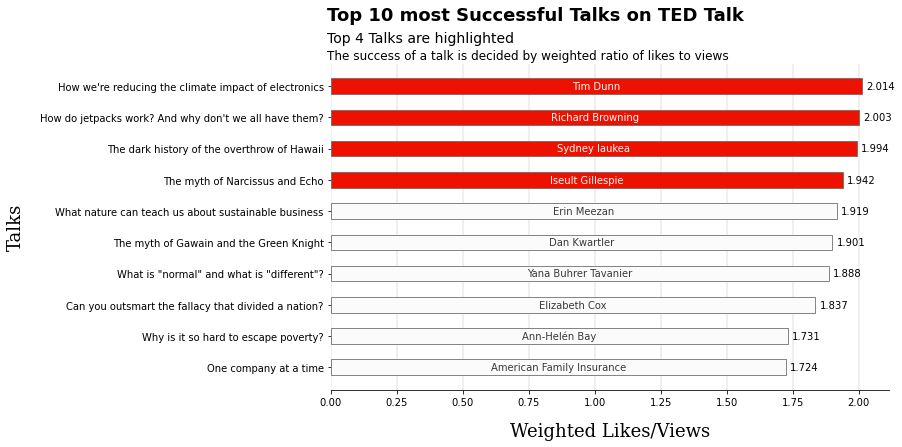

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

fig.text(0.12,0.98, "Top 10 most Successful Talks on TED Talk", fontsize=18, fontweight='600')
fig.text(0.12,0.93, "Top 4 Talks are highlighted", fontsize=14, fontweight='500')
fig.text(0.12,0.89, "The success of a talk is decided by weighted ratio of likes to views", fontsize=12, fontweight='100')

ax.barh(x_title,y_wt_likes_views, height=0.5, edgecolor='#686868', linewidth=0.8, color=colormap)

for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", xy=(p.get_x()+p.get_width()+0.07, p.get_y()+p.get_height()/2), va='center', ha='center')

for i, p in enumerate(ax.patches):
    ax.annotate(f"{a_authors[i]}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()/2), va='center', ha='center', color=colormap_annotate[i])
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(axis='x', linewidth=0.4)
ax.set_axisbelow(True)

plt.xlabel("Weighted Likes/Views", fontfamily='serif', fontsize=18, labelpad=15)
plt.ylabel("Talks", fontfamily='serif', fontsize=18, labelpad=15)
plt.show()

> **OBSERVATIONS**
> * Top 10 Successful Talks are shown in the above plot
> * Success of a Talk is calculated by the weighted ratio of Likes to Views of the video of the Talk
> * Weighted ratio of a video is calculated as the **Product of Ratio of Likes to Views and Inverse of Number of Days passed from the Date of Posting of Video till 1st July 2022 and multiplying it by 100**
> * The most successful talk is **"How we're reducing the climate impact of electronics"** by	**Tim Dunn** followesd closely by **"How do jetpacks work? And why don't we all have them?"** by **Richard Browning**, **"The dark history of the overthrow of Hawaii"** by **Sydney Iaukea** and **"The myth of Narcissus and Echo"** by **Iseult Gillespie**

**Plotting a Scatter Plot between Views and Likes of the TED Talk videos**

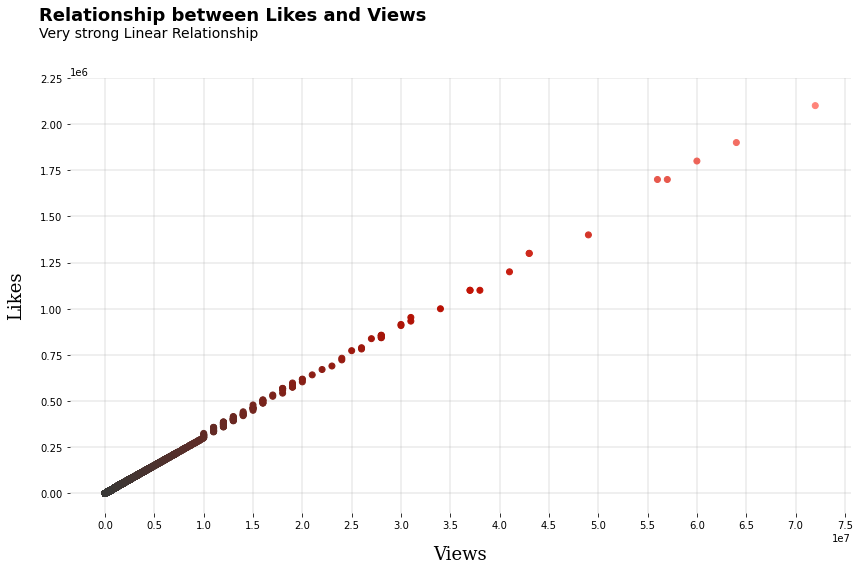

In [40]:
c_map=cm.LinearSegmentedColormap.from_list("",['#393836', '#bf0e00', '#ff847a'])

fig, ax = plt.subplots(1, 1, figsize=(14,8))

fig.text(0.095,0.98, "Relationship between Likes and Views", fontsize=18, fontweight='600')
fig.text(0.095,0.95, "Very strong Linear Relationship", fontsize=14, fontweight='500')
#fig.text(0.12,0.89, "The success of a talk is decided by weighted ratio of likes to views", fontsize=12, fontweight='100')

ax.scatter(df['Views'].values, df['Likes'].values, c=df['Likes'].values, cmap=c_map, alpha=1)

ax.set_xticks(list(range(0,80000000,5000000)))
ax.set_yticks(list(range(0,2500000,250000)))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(linewidth=0.4)
ax.set_axisbelow(True)

plt.xlabel("Views", fontfamily='serif', fontsize=18, labelpad=15)
plt.ylabel("Likes", fontfamily='serif', fontsize=18, labelpad=15)

plt.show()

> **OBSERVATIONS**
> * We find that there is a very strong linear relationship between **Views** and **Likes**

**Plotting a Word Cloud of the common words in the text of 'title' column**

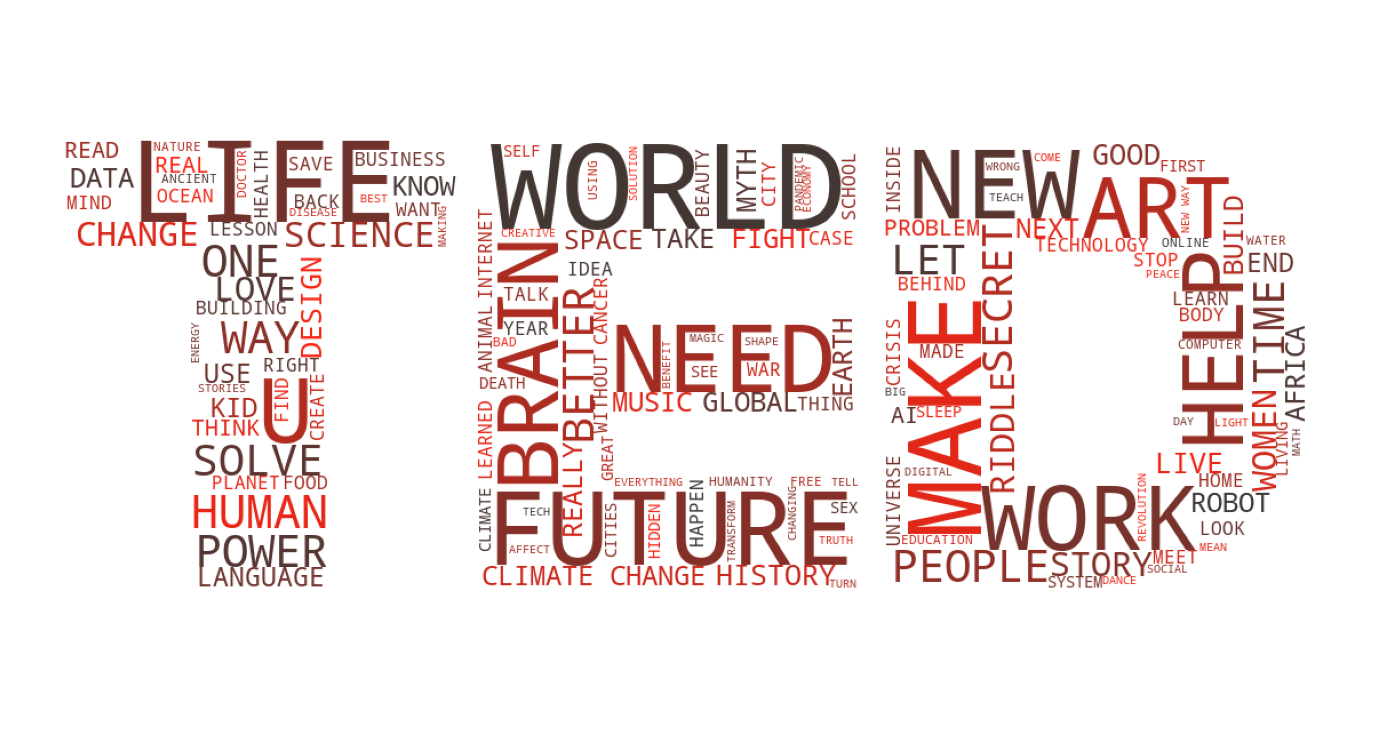

In [41]:
c_map=cm.LinearSegmentedColormap.from_list("",['#393836', '#fd2413'])

text=''
for line in df['Preprocessed_Title'].values:
    text+=' '.join(line.split())+' '
    
img_arr=np.array(Image.open('C:\\Users\\ASUS\\Desktop\\DS ipynb\\TED.png')) #Please download the "TED.png" file and copy the file location in the adjacent location

wordcloud=WordCloud(background_color='white', width=500, height=500, colormap=c_map, min_font_size=10, mask=img_arr).generate(text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

> **OBSERVATIONS**
> * The most common words used in the **Title** are **WORLD**, **FUTURE**, **LIFE**, **MAKE**, **WORK**, **NEED** etc.

<h2> 5. Conclusion </H2>

> * A new feature is added which is the Weighted ratio of likes to views. The Weighted ratio is calculated as the Product of Ratio of Likes to Views and Inverse of Number of Days passed from the Date of Posting of Video till 1st July 2022 and multiplying it by 100
> * Most of the TED Talks have happened in recent years with a considerable jump happening in the year **2009**
> * Most of the talks took place in the month of **February** and **November**
> * **Alex Gendler** gave the most number of talks followed by **Iseult Gillespie**
> * **Alex Gendler** got the most number of total views and likes on the videos of his Talks followed by **Sir Ken Robinson**
> * **Iseult Gillespie** turned out to be the most Successful author followed closely by **Alex Gendler** and **Matt Walker**
> * **"How we're reducing the climate impact of electronics"** by **Tim Dunn** is the most Successful Talk followed closely by **"How do jetpacks work? And why don't we all have them?"** by **Richard Browning**, **"The dark history of the overthrow of Hawaii"** by **Sydney Iaukea** and **"The myth of Narcissus and Echo"** by **Iseult Gillespie**
> * We found that **Views** and **Likes** have a very Strong Linear Relationship
> * Some of the most common Words used in **Title** are **WORLD**, **FUTURE**, **LIFE**, **MAKE**, **WORK**, **NEED**

<h2> 6. Reference </H2>

* Matplotlib - https://matplotlib.org
* Pandas - https://pandas.pydata.org
* TED - www.ted.com
* Visualization help - https://www.kaggle.com/code/joshuaswords/netflix-data-visualization/